In [2]:
import os
import numpy as np
import cv2
import argparse
import torch
from torchvision.datasets import VOCDetection
from torchvision.transforms import Compose, ToTensor, RandomAffine, ColorJitter
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.cuda.amp import GradScaler, autocast
from torch.optim import AdamW
from pprint import pprint
from tqdm.autonotebook import tqdm

torch.multiprocessing.set_sharing_strategy('file_system')


# Download dataset


In [3]:
class VOCDataset(VOCDetection):
    def __init__(self,root,year,image_set,download,transform):
        super().__init__(root,year,image_set, download,transform)
        self.categories = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
                       'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                       'diningtable', 'dog', 'horse', 'motorbike', 'person',
                       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
    def __getitem__(self,item):
        image,data = super().__getitem__(item)
        bboxes = []
        labels = []
        for obj in data['annotation']['object']:
            bboxes.append([
              int(obj['bndbox']['xmin']),
              int(obj['bndbox']['ymin']),
              int(obj['bndbox']['xmax']),
              int(obj['bndbox']['ymax']),
            ])
            labels.append(self.categories.index(obj['name']))
        bboxes = torch.FloatTensor(bboxes)
        labels = torch.LongTensor(labels)
        target = {
            'boxes':bboxes,
            'labels' : labels
        }
        return image,target
transform = ToTensor()
dataset = VOCDataset(
    root='/kaggle/working',
    year='2012',
    image_set="train",
    download=True,
    transform=transform
)


100%|██████████| 1999639040/1999639040 [01:05<00:00, 30363073.61it/s]


Extracting /kaggle/working/VOCtrainval_11-May-2012.tar to /kaggle/working


In [4]:
image,target = dataset[1500]
pprint(type(image))
pprint(image.shape)
pprint(target)

<class 'torch.Tensor'>
torch.Size([3, 500, 375])
{'boxes': tensor([[ 57.,  47., 182., 336.],
        [112.,  99., 318., 498.]]),
 'labels': tensor([8, 8])}


In [5]:
!pip install wget

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=db748fa767e9025608bd3b22242d33b41e14a9fa3a6c910c32c49f4967921b42
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


# Training


In [6]:
import os
import numpy as np
import argparse
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, RandomAffine, ColorJitter
from tqdm.autonotebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint
from torch.cuda.amp import GradScaler, autocast
from torch.optim import AdamW
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

torch.multiprocessing.set_sharing_strategy('file_system')

In [7]:
import argparse

def get_arg(**kwargs):
    parser = argparse.ArgumentParser(description='Train Faster R-CNN')
    parser.add_argument('--data_path', '-d', type=str, default='/content/drive/MyDrive/Faster_R_CNN_project/Dataset', help='Path to dataset')
    parser.add_argument("--year", "-y", type=str, default="2012")
    parser.add_argument('--num_epochs', '-n', type=int, default=100, help='Number of epochs')
    parser.add_argument('--batch_size', '-b', type=int, default=4, help='Batch size')
    parser.add_argument('--learning_rate', '-l', type=float, default=1e-3, help='Learning rate')
    parser.add_argument('--momentum', '-m', type=float, default=0.9, help='Momentum')
    parser.add_argument('--log_folder', '-p', type=str, default='tensorboard/pascal_voc', help='Path to generate log folder')
    parser.add_argument('--checkpoint_folder', '-c', type=str, default='checkpoint', help='Path to generate checkpoint folder')
    parser.add_argument("--saved_checkpoint", "-o", type=str, default=None, help="Continue from this checkpoint")
    
    # Convert kwargs to a list of arguments
    args_list = []
    for key, value in kwargs.items():
        args_list.append(f'--{key}')
        args_list.append(str(value))
    
    args = parser.parse_args(args_list)
    return args
#test func
arg = get_arg(data_path='/kaggle/working', num_epochs=2)
print(arg)

Namespace(data_path='/kaggle/working', year='2012', num_epochs=2, batch_size=4, learning_rate=0.001, momentum=0.9, log_folder='tensorboard/pascal_voc', checkpoint_folder='checkpoint', saved_checkpoint=None)


In [8]:

def collate_fn(batch):
    images, labels = zip(*batch)
    return list(images), list(labels)



## Create folder to store checkpoint and tensorboard

In [9]:
def create_folders(base_path="/kaggle/working"):
    folders = ["checkpoint", "tensorboard"]
    for folder in folders:
        path = os.path.join(base_path, folder)
        os.makedirs(path, exist_ok=True)
    print(f"Folders {folders} created inside {base_path}")

# Call the function
create_folders()

Folders ['checkpoint', 'tensorboard'] created inside /kaggle/working


In [10]:
path = os.path.join('/kaggle/working/tensorboard', 'pascal_voc')
os.makedirs(path, exist_ok=True)

## Training data

In [11]:

def train_data(args):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Define transformations
    train_transform = Compose([
        RandomAffine(
            degrees=(-5, 5),
            translate=(0.15, 0.15),
            scale=(0.85, 1.15),
            shear=10
        ),
        ColorJitter(
            brightness=0.125,
            contrast=0.5,
            saturation=0.5,
            hue=0.05
        ),
        ToTensor(),  # No need to Normalize
    ])
    
    # Load datasets
    train_dataset = VOCDataset(
        root=args.data_path,
        year=args.year,
        image_set="train",
        download=False,
        transform=train_transform
    )
    val_dataset = VOCDataset(
        root=args.data_path,
        year=args.year,
        image_set="val",
        download=False,
        transform=ToTensor()
    )
    
    # Create dataloaders
    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=4,
        collate_fn=collate_fn
    )
    val_dataloader = DataLoader(
        dataset=val_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )
    # fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
    # Load model
    model = fasterrcnn_resnet50_fpn(
        weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
        trainable_backbone_layers= 2 # half layer are trainable
    ).to(device)
    in_channels = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_channels,
                                                      num_classes=len(train_dataset.categories))

    model = model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=args.learning_rate)
    scaler = GradScaler()
    writer = SummaryWriter(log_dir=args.log_folder)
    best_map = 0.0

    for epoch in range(args.num_epochs):
        model.train()
        for iter, (images, labels) in enumerate(train_dataloader):
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in labels]

            optimizer.zero_grad()
            with autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
            
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()

            if iter % 10 == 0:
                print(f"Epoch [{epoch}/{args.num_epochs}], Iter [{iter}/{len(train_dataloader)}], Loss: {losses.item()}")

        # Validation
        model.eval()
        metric = MeanAveragePrecision(iou_type="bbox")
        for iter, (images, labels) in enumerate(val_dataloader):
            images = [image.to(device) for image in images]
            with torch.no_grad():
                outputs = model(images)
            preds = []

            for output in outputs:
                preds.append({
                    "boxes": output["boxes"].to("cpu"),
                    "scores": output["scores"].to("cpu"),
                    "labels": output["labels"].to("cpu"),
                })

            targets = []
            for label in labels:
                targets.append({
                    "boxes": label["boxes"],
                    "labels": label["labels"],
                })
            metric.update(preds, targets)
        
        result = metric.compute()
        pprint(result)
        writer.add_scalar("Val/mAP", result["map"], epoch)
        writer.add_scalar("Val/mAP_50", result["map_50"], epoch)
        writer.add_scalar("Val/mAP_75", result["map_75"], epoch)

        checkpoint = {
            "model_state_dict": model.state_dict(),
            "map": result["map"],
            "epoch": epoch + 1,
            "optimizer_state_dict": optimizer.state_dict()
        }
        torch.save(checkpoint, os.path.join(args.checkpoint_folder, "last.pt"))
        if result["map"] > best_map:
            best_map = result["map"]
            torch.save(checkpoint, os.path.join(args.checkpoint_folder, "best.pt"))


In [12]:
!pip install torchmetrics[detection]

In [13]:
pip install faster-coco-eval

  Using cached faster_coco_eval-1.6.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
Using cached faster_coco_eval-1.6.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (450 kB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
# pip install --force-reinstall faster-coco-eval

In [15]:
pip install pycocotools

Note: you may need to restart the kernel to use updated packages.


In [16]:
args = get_arg(data_path='/kaggle/working', num_epochs=5,batch_size = 4)
train_data(args)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 165MB/s]  
/tmp/ipykernel_86/1721163441.py:65: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/tmp/ipykernel_86/1721163441.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [0/5], Iter [0/1430], Loss: 3.678013324737549
Epoch [0/5], Iter [10/1430], Loss: 0.5357467532157898
Epoch [0/5], Iter [20/1430], Loss: 0.5875566005706787
Epoch [0/5], Iter [30/1430], Loss: 0.9333852529525757
Epoch [0/5], Iter [40/1430], Loss: 0.23599986732006073
Epoch [0/5], Iter [50/1430], Loss: 0.6466628313064575
Epoch [0/5], Iter [60/1430], Loss: 0.8658648729324341
Epoch [0/5], Iter [70/1430], Loss: 0.5960858464241028
Epoch [0/5], Iter [80/1430], Loss: 0.6307034492492676
Epoch [0/5], Iter [90/1430], Loss: 0.4928876459598541
Epoch [0/5], Iter [100/1430], Loss: 0.5756245255470276
Epoch [0/5], Iter [110/1430], Loss: 0.3127584755420685
Epoch [0/5], Iter [120/1430], Loss: 0.8808276057243347
Epoch [0/5], Iter [130/1430], Loss: 0.6239097118377686
Epoch [0/5], Iter [140/1430], Loss: 0.4487128257751465
Epoch [0/5], Iter [150/1430], Loss: 0.46447283029556274
Epoch [0/5], Iter [160/1430], Loss: 0.5793875455856323
Epoch [0/5], Iter [170/1430], Loss: 0.5298470258712769
Epoch [0/5], Iter [1

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20], dtype=torch.int32),
 'map': tensor(0.0015),
 'map_50': tensor(0.0065),
 'map_75': tensor(0.0002),
 'map_large': tensor(0.0022),
 'map_medium': tensor(0.0005),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.),
 'mar_1': tensor(0.0109),
 'mar_10': tensor(0.0259),
 'mar_100': tensor(0.0277),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.0385),
 'mar_medium': tensor(0.0005),
 'mar_small': tensor(0.)}
Epoch [1/5], Iter [0/1430], Loss: 0.22355803847312927
Epoch [1/5], Iter [10/1430], Loss: 0.4430053234100342
Epoch [1/5], Iter [20/1430], Loss: 0.5700644254684448
Epoch [1/5], Iter [30/1430], Loss: 0.6995648145675659
Epoch [1/5], Iter [40/1430], Loss: 0.6715119481086731
Epoch [1/5], Iter [50/1430], Loss: 0.3298323452472687
Epoch [1/5], Iter [60/1430], Loss: 0.39717766642570496
Epoch [1/5], Iter [70/1430], Loss: 0.2319488674402237
Epoch [1/5], Iter [80/1430], Loss: 0.21

# Testing with new input

In [ ]:
# fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

In [17]:
import argparse

def get_arg(**kwargs):
    parser = argparse.ArgumentParser(description="Test Faster R-CNN model")
    parser.add_argument("--image_path", "-i", type=str, help="Path to image", required=True)
    parser.add_argument("--saved_checkpoint", "-o", type=str, default="checkpoint/best.pt", help="Load from this checkpoint")
    parser.add_argument("--conf_threshold", "-c", type=float, default=0.3, help="Confidence threshold")
    parser.add_argument("--print_map", "-p", type=bool, default=False, help="Displace mAP score")

    
    # Convert kwargs to a list of arguments
    args_list = []
    for key, value in kwargs.items():
        args_list.append(f'--{key}')
        args_list.append(str(value))
    
    args = parser.parse_args(args_list)
    return args

arg = get_arg(image_path='/kaggle/input/my-dataset/bycycle.jpg')
print(arg)
categories = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair',
              'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
              'train', 'tvmonitor']

Namespace(image_path='/kaggle/input/my-dataset/bycycle.jpg', saved_checkpoint='checkpoint/best.pt', conf_threshold=0.3, print_map=False)


In [18]:
import os
import numpy as np
import cv2
import argparse
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

torch.multiprocessing.set_sharing_strategy('file_system')

def test(args,d = False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load the model
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_channels = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_channels, num_classes=21)
    
    # Load the checkpoint
    checkpoint = torch.load(args.saved_checkpoint, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.float()
    model.to(device)
    
    # Load and preprocess the image
    ori_image = cv2.imread(args.image_path)
    image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
    image = np.transpose(image, (2, 0, 1)) / 255.0
    image = [torch.from_numpy(image).to(device).float()]
    
    #displace map score
    if args.print_map:
        map_value = checkpoint["map"]
        print("MAP:", map_value)
    
    # Perform inference
    model.eval()
    with torch.no_grad():
        output = model(image)[0]
        bboxes = output["boxes"]
        labels = output["labels"]
        scores = output["scores"]
        
        # Draw bounding boxes and labels on the image
        for bbox, label, score in zip(bboxes, labels, scores):
            if score > args.conf_threshold:
                xmin, ymin, xmax, ymax = bbox
                cv2.rectangle(ori_image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 0, 255), 3)
                category = categories[label]
                cv2.putText(ori_image, category, (int(xmin), int(ymin)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3, cv2.LINE_AA)
        
        # Save the result
        cv2.imwrite("prediction.jpg", ori_image)



In [25]:
image_path='/kaggle/input/my-dataset/chair.jpg'
args = get_arg(image_path=image_path, conf_threshold = 0.7,print_map = True)
test(args)

/tmp/ipykernel_86/3238162438.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.saved_checkpoint, map_location=device)


MAP: tensor(0.0084, device='cuda:0')


original img:


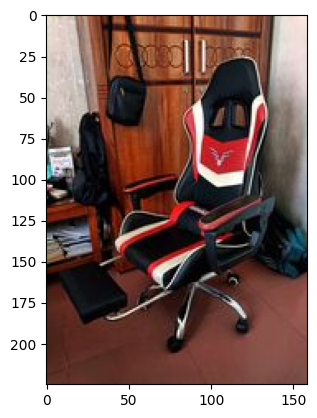

In [26]:


from PIL import Image
import matplotlib.pyplot as plt
print('original img:')
img = Image.open(image_path)
plt.imshow(img)
plt.show()

prediction:


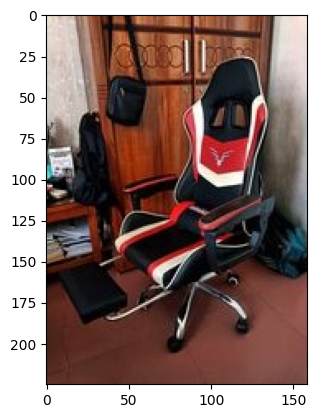

In [27]:

from PIL import Image
import matplotlib.pyplot as plt
print('prediction:')
img = Image.open('/kaggle/working/prediction.jpg')
plt.imshow(img)
plt.show()